<a href="https://colab.research.google.com/github/geun-hyoung/python_local_outlier_factor_text_info/blob/main/lof_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting

In [ ]:
# 세션 다시 시작
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!pip install gensim
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pyLDAvis
!pip install tqdm
!pip install transformers
!pip install keybert
!pip install umap-learn
!pip install ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd

import spacy
from bs4 import BeautifulSoup

Mounted at /content/drive


In [ ]:
import json

# attraction_path = '/content/drive/MyDrive/Colab Notebooks/inbound_service/dataset/attraction_info.json'

# # JSON 파일 읽기
# with open(attraction_path, 'r', encoding='utf-8') as file:
#     data = json.load(file)

# # JSON 데이터 확인
# if isinstance(data, list):  # 리스트 형태의 JSON
#     attraction_df = pd.json_normalize(data)
# elif isinstance(data, dict):  # 딕셔너리 형태의 JSON
#     if "key_with_nested_data" in data:  # 중첩된 키가 있는 경우
#         attraction_df = pd.json_normalize(data, record_path='key_with_nested_data', meta=['parent_key1', 'parent_key2'])
#     else:
#         attraction_df = pd.json_normalize(data)
# else:
#     raise ValueError("Unsupported JSON structure.")

attraction_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/translated_tourist_attractions.csv')

# 데이터프레임 확인
attraction_df.head()

,searched_name,search_result,attraction_info,source,similarity,english_info
0,에버랜드,에버랜드,"1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...",second,100.0,This theme park offers enjoyable relaxation an...
1,리움 미술관,리움 미술관,삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...,second,100.0,The Samsung Cultural Foundation has contribute...
2,협재해수욕장,협재해수욕장,협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...,second,100.0,"Hyeopjae Beach is adjacent to Hallim Park, 32k..."
3,레고랜드 코리아 리조트,레고랜드 코리아 리조트,레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...,second,100.0,"LEGOLAND® Korea Resort, located in Jungdo, Chu..."
4,익선동 한옥거리,익선동 한옥거리,"익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...",second,100.0,Ikseon-dong is a place where alleys and hanoks...


In [ ]:
attraction_df.shape

(1665, 6)

In [ ]:
# 관광지 중복 제거: version 1
attraction_df_cleaned = attraction_df.dropna(subset=['searched_name'])  # 결측치 제거
attraction_df_cleaned['info'] = attraction_df_cleaned['searched_name'].str.strip()  # 공백 제거
attraction_df_cleaned = attraction_df_cleaned[attraction_df_cleaned['searched_name'] != '']  # 빈 문자열 제거
attraction_df_cleaned = attraction_df_cleaned.drop_duplicates(subset=['searched_name'])  # 중복 제거

# 결과 shape 출력
print(f"Shape of cleaned DataFrame: {attraction_df_cleaned.shape}")

Shape of cleaned DataFrame: (1386, 7)


<ipython-input-4-194f44fead55>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attraction_df_cleaned['info'] = attraction_df_cleaned['searched_name'].str.strip()  # 공백 제거


In [ ]:
# # 관광지 ifno 중복 제거: version 2
# attraction_df_cleaned = attraction_df.dropna(subset=['info'])  # 결측치 제거
# attraction_df_cleaned['info'] = attraction_df_cleaned['info'].str.strip()  # 공백 제거
# attraction_df_cleaned = attraction_df_cleaned[attraction_df_cleaned['info'] != '']  # 빈 문자열 제거
# attraction_df_cleaned = attraction_df_cleaned.drop_duplicates(subset=['info'])  # 중복 제거

# # 결과 shape 출력
# print(f"Shape of cleaned DataFrame: {attraction_df_cleaned.shape}")

In [ ]:
# 'type' 열 확인
if 'type' in attraction_df_cleaned.columns:
    # 'type' 열에서 제외할 유형이 포함되지 않은 행 필터링
    exclude_types = {'Taxis & Shuttles', 'Gear Rentals', 'Visitor Centers', 'Cooking Classes'}
    attraction_df_filtered = attraction_df_cleaned[
        ~attraction_df_cleaned['type'].apply(lambda x: any(t in exclude_types for t in x))
    ]

else:
    print("'type' column not found in the DataFrame. Please check the data structure.")

print(f"Shape of filtered DataFrame: {attraction_df_filtered.shape}")

Shape of filtered DataFrame: (7918, 7)


In [ ]:
import json

review_path = "/content/drive/MyDrive/Colab Notebooks/inbound_service/local_outlier_factor_analysis/reviews_info.json"

# JSON 파일 읽기
with open(review_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터 확인
if isinstance(data, list):  # 리스트 형태의 JSON
    review_df = pd.json_normalize(data)
elif isinstance(data, dict):  # 딕셔너리 형태의 JSON
    if "key_with_nested_data" in data:  # 중첩된 키가 있는 경우
        review_df = pd.json_normalize(data, record_path='key_with_nested_data', meta=['parent_key1', 'parent_key2'])
    else:
        review_df = pd.json_normalize(data)
else:
    raise ValueError("Unsupported JSON structure.")

# 데이터프레임 확인
review_df.head()

,attraction_name,name,contributions,location,score,tag,date,content,profileUrl
0,Gyeongbokgung Palace,Tom F,37,,5,nice palace,Nov 2024 • Couples,"There are several palaces in downtown Seoul, a...",https://www.tripadvisor.com/Profile/W6358IDtomf
1,Gyeongbokgung Palace,eriquef2017,29,"Puerto Escondido, Mexico",5,History surrounding you!,Oct 2024 • Couples,Exceptionally preserved and restored history o...,https://www.tripadvisor.com/Profile/eriquef2017
2,Gyeongbokgung Palace,colin h,73,"Ely, United Kingdom",5,Must see palace if in Seoul.,Nov 2024 • Solo,The largest of the palaces in Seoul and it doe...,https://www.tripadvisor.com/Profile/colinhaley812
3,Gyeongbokgung Palace,Natari,33,"Almaty, Kazakhstan",5,Experience the spirit of Korea,Sep 2024 • Solo,"Undoubtedly, it’s a must see place, especially...",https://www.tripadvisor.com/Profile/W7498XRnat...
4,Gyeongbokgung Palace,Luc,442,"Brisbane, Australia",5,Must visit in Seoul,Oct 2024 • Friends,This is a huge palace and stunning to explore....,https://www.tripadvisor.com/Profile/luci321


In [ ]:
review_df.shape

(273622, 9)

In [ ]:
# 관광지별 리뷰 개수 계산
review_counts = review_df['attraction_name'].value_counts()

# 리뷰 개수가 5개 이상 20개 이하인 관광지 필터링
filtered_attractions = review_counts[(review_counts >= 5) & (review_counts <= 20)].index

# df에서 필터링된 관광지에 해당하는 데이터 추출
train_df = attraction_df_filtered[attraction_df_filtered['name'].isin(filtered_attractions)]

# 리뷰 데이터 통합: 리뷰를 하나의 문자열로 결합
review_combined = review_df.groupby('attraction_name')['content'].apply(lambda x: ' '.join(x))

# 'reviews' 열 추가: 각 관광지의 리뷰를 통합한 문자열
train_df['reviews'] = train_df['name'].map(review_combined)

train_df.head()

<ipython-input-12-d8ba2665376c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['reviews'] = train_df['name'].map(review_combined)


,url,name,type,review_score,info,duration,location,reviews
92,https://www.tripadvisor.com/Attraction_Review-...,Boksoondoga,[Distilleries],5.0,Boksoondoga,< 1 hour,"48, Hyangsandong-gil, Sangbuk-myeon, Ulsan 449...",// 𝘽𝙤𝙠𝙨𝙤𝙤𝙣𝙙𝙤𝙜𝙖 𝙈𝙖𝙠𝙜𝙚𝙤𝙡𝙡𝙞 - 복순도가 福順都家 🤍 /...
145,https://www.tripadvisor.com/Attraction_Review-...,Yongin Daejanggeum Park,[Amusement & Theme Parks],4.5,Yongin Daejanggeum Park,Explore different ways to experience this place.,"25, Yongcheon drama-gil, Baegam-myeon, Cheoin-...",I went to this park with my wife as part of he...
146,https://www.tripadvisor.com/Attraction_Review-...,Dumulmeori,"[Bodies of Water, Points of Interest & Landmarks]",4.5,Dumulmeori,Explore different ways to experience this place.,"Yangsu-ri, Yangseo-myeon, Yangpyeong-gun, Gyeo...",I went in Nov 2019 during my solo autumn trip....
151,https://www.tripadvisor.com/Attraction_Review-...,Seonamsa Temple,[Religious Sites],4.5,Seonamsa Temple,,"802, SanJukhak-ri, Seungju-eup, Suncheon, Jeol...",This is the first time to visit the countrysid...
168,https://www.tripadvisor.com/Attraction_Review-...,Anmok Beach,[Beaches],4.5,Anmok Beach,Explore different ways to experience this place.,,"If they like the sea, then the best place to g..."


In [ ]:
train_df.shape

(953, 8)

In [ ]:
import pandas as pd
import re
import spacy

# ✅ 데이터프레임 복사
preprocessed_df = attraction_df.copy()

# ✅ spaCy 모델 로드
nlp = spacy.load('en_core_web_sm')

# ✅ 정규식 패턴 정의
english_word_regex = re.compile(r'^[a-z]+$')  # 영어 소문자만 남기기
non_english_or_digit_regex = re.compile(r'[^\x00-\x7F]+|\d')  # 한국어, 숫자, 기타 비영어 문자 제거

# ✅ 전처리 함수 정의
def preprocess_text(text):
    if not isinstance(text, str):  # 문자열이 아닌 경우 빈 문자열 반환
        return None

    # 1️⃣ 정규식을 사용하여 숫자, 한국어, 특수 문자 제거
    text = text.lower()  # 소문자화
    text = re.sub(non_english_or_digit_regex, '', text)  # 숫자 및 비영어 문자 제거

    # 2️⃣ spaCy를 사용한 텍스트 분석 (토큰화 포함)
    doc = nlp(text)

    # 3️⃣ 토큰화, 표제어 추출 및 불필요한 토큰 제거
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha  # 알파벳으로만 이루어진 토큰
        and len(token) >= 2  # 2글자 이상 단어
        and not token.is_stop  # 불용어 제거
        and token.pos_ in ['ADJ', 'NOUN', 'VERB']  # 형용사, 명사, 동사만 유지
        and token.pos_ != 'PROPN'  # 고유명사 제거
        and english_word_regex.match(token.lemma_)  # 영어 단어만 유지
    ]

    # 4️⃣ 5개 미만 단어 제거
    if len(tokens) < 5:
        return None

    # 최종 토큰 리스트를 문자열로 변환
    return ' '.join(tokens)

# ✅ 'english_info' 컬럼에 전처리 적용
preprocessed_df['corpus'] = preprocessed_df['english_info'].apply(preprocess_text)

# ✅ None 값 제거 및 인덱스 초기화
preprocessed_df = preprocessed_df.dropna(subset=['corpus']).reset_index(drop=True)

# ✅ 결과 확인
print(preprocessed_df.shape)
preprocessed_df.head()

(1397, 7)


,searched_name,search_result,attraction_info,source,similarity,english_info,corpus
0,에버랜드,에버랜드,"1년 365일, 계절별 다채롭게 펼쳐지는 축제와 어트랙션, 동물, 식물 등 다양한 ...",second,100.0,This theme park offers enjoyable relaxation an...,theme park offer enjoyable relaxation joy day ...
1,리움 미술관,리움 미술관,삼성문화재단은 1965년 설립 이래로 한국문화예술 발전을 위해 기여해 왔다. 삼성그...,second,100.0,The Samsung Cultural Foundation has contribute...,contribute development korean culture art esta...
2,협재해수욕장,협재해수욕장,협재해수욕장은 제주시 서쪽 32km 거리의 한림공원에 인접해 있다. 조개껍질 가루가...,second,100.0,"Hyeopjae Beach is adjacent to Hallim Park, 32k...",beach adjacent scenery beautiful white sand mi...
3,레고랜드 코리아 리조트,레고랜드 코리아 리조트,레고랜드 코리아 리조트(LEGOLAND® Korea Resort)는 강원도 춘천시 ...,second,100.0,"LEGOLAND® Korea Resort, located in Jungdo, Chu...",locate chuncheon global theme park th legoland...
4,익선동 한옥거리,익선동 한옥거리,"익선동은 골목과 한옥이 어우러져 아름다운 매력을 풍기는 곳으로, 남녀노소 많은 관광...",second,100.0,Ikseon-dong is a place where alleys and hanoks...,dong place alley hanok come create beautiful c...


### SentenceTransformer 임베딩

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

model = SentenceTransformer('all-MiniLM-L6-v2')  # 빠르고 효율적인 모델
embeddings = model.encode(preprocessed_df['corpus'], convert_to_tensor=False)
preprocessed_df['embedding'] = embeddings.tolist()

# 정규화
scaler = StandardScaler()
embedding_vectors = scaler.fit_transform(preprocessed_df['embedding'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# from keybert import KeyBERT
# from sklearn.preprocessing import StandardScaler
# # KeyBERT를 이용한 키워드 추출
# kw_model = KeyBERT(model='all-MiniLM-L6-v2')
# preprocessed_df['keywords'] = preprocessed_df['description'].apply(
#     lambda x: ", ".join([kw[0] for kw in kw_model.extract_keywords(x, top_n=5)])
# )

# # description에 키워드 결합
# preprocessed_df['extended_description'] = (
#     preprocessed_df['description'] + " Keywords: " + preprocessed_df['keywords']
# )

# # 새로운 description을 임베딩
# embeddings = model.encode(preprocessed_df['extended_description'], convert_to_tensor=False)
# preprocessed_df['embedding'] = embeddings.tolist()

# # 4. 임베딩 정규화
# scaler = StandardScaler()
# embedding_vectors = scaler.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


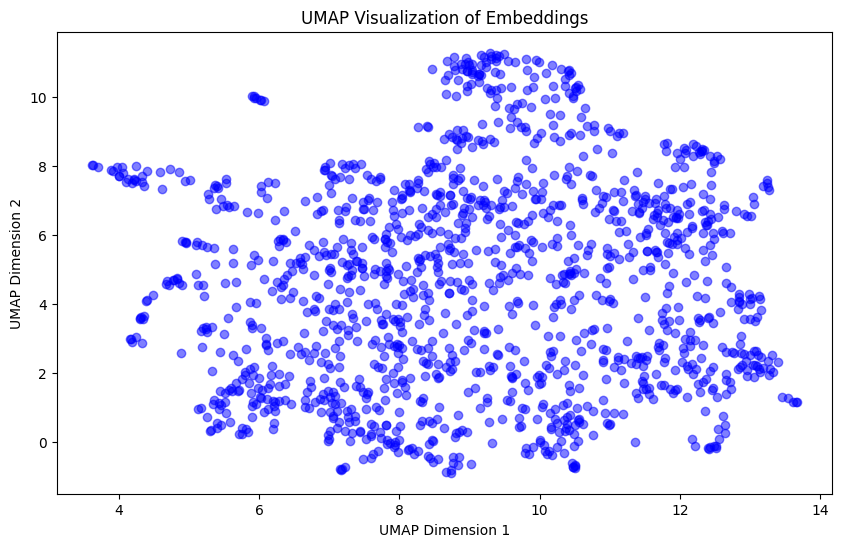

In [ ]:
import matplotlib.pyplot as plt
import umap

umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embedding_vectors)

# UMAP 시각화
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, c='blue')

plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

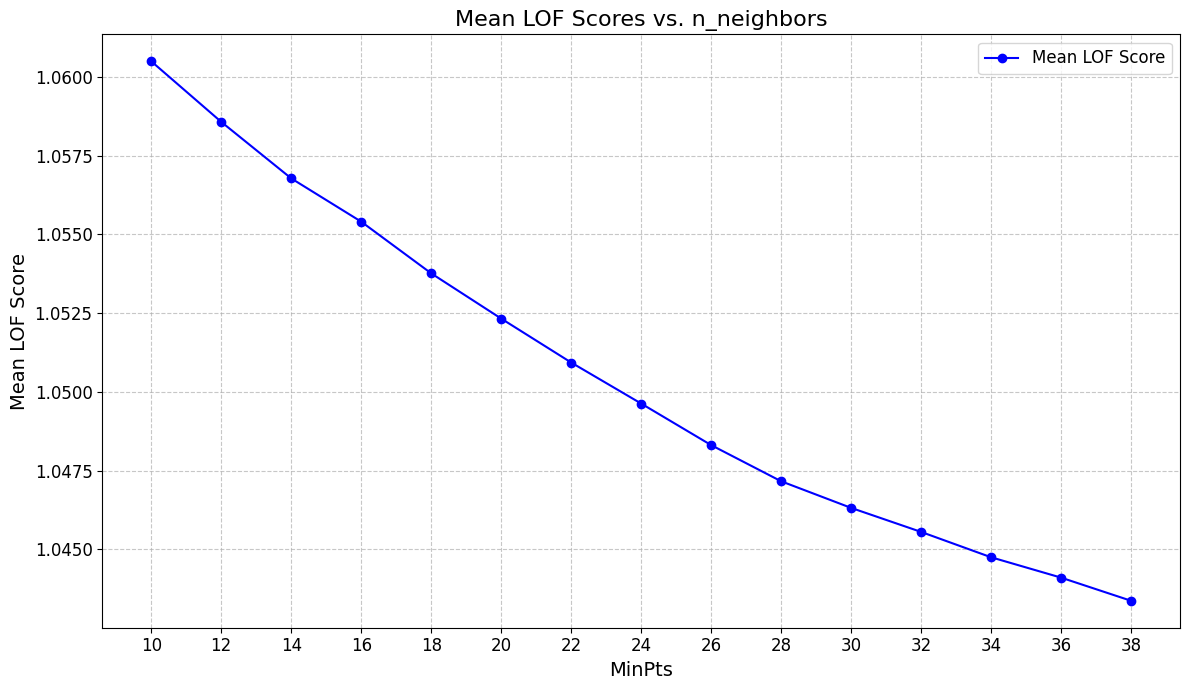

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# LOF 실험 범위 설정 (5부터 30까지 2씩 증가)
n_neighbors_range = range(10, 40, 2)

# 각 n_neighbors의 평균 LOF 점수 저장
lof_mean_scores = []

for n in n_neighbors_range:
    lof = LocalOutlierFactor(n_neighbors=n, metric='euclidean', novelty=False)
    lof.fit_predict(embedding_vectors)  # LOF 점수 계산
    lof_scores = -lof.negative_outlier_factor_  # LOF 점수 추출
    mean_lof_score = lof_scores.mean()
    lof_mean_scores.append((n, mean_lof_score))

# 결과 정리
lof_mean_df = pd.DataFrame(lof_mean_scores, columns=['n_neighbors', 'mean_lof_score'])

# 시각화
plt.figure(figsize=(12, 7))
plt.plot(lof_mean_df['n_neighbors'], lof_mean_df['mean_lof_score'], marker='o', linestyle='-', color='b', label='Mean LOF Score')
plt.title("Mean LOF Scores vs. n_neighbors", fontsize=16)
plt.xlabel("MinPts", fontsize=14)
plt.ylabel("Mean LOF Score", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(lof_mean_df['n_neighbors'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# LOF 적용
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit(embedding_vectors)
preprocessed_df['LOF_Score'] = -lof.negative_outlier_factor_  # LOF 점수
preprocessed_df['is_outlier'] = lof.fit_predict(embedding_vectors)  # -1: 이상치, 1: 정상치

# LOF 점수에 따라 정렬
sorted_df = preprocessed_df.sort_values(by='LOF_Score', ascending=False)

In [ ]:
# 각 관광지의 리뷰 개수 계산
review_counts = review_df['attraction_name'].value_counts()

# 리뷰 수를 `sorted_df`에 추가
sorted_df['Review_Count'] = sorted_df['name'].map(review_counts).fillna(0).astype(int)

In [ ]:
sorted_df.head(10)

,searched_name,search_result,attraction_info,source,similarity,english_info,corpus,embedding,LOF_Score,is_outlier
516,용화해변,용화해변\n,용화해변은 삼척시 근덕면에 위치한 작은 해수욕장이다. 삼척 시내에서 남쪽으로 24k...,first,88.89,Yonghwa Beach is a small beach located in Samc...,beach small beach locate km city wave high str...,"[-0.013394271023571491, 0.0223800428211689, 0....",1.411338,1
950,세병관,통영 세병관,세병관은 이경준 제6대 통제사가 통제영을 이 고장 두룡포에 옮겨온 이듬해인 선조 3...,second,66.67,세병관은 이경준 제6대 통제사가 통제영을 이 고장 두룡포에 옮겨온 이듬해인 선조 3...,beam large platform erect support beam step pl...,"[0.03131087124347687, 0.07726991176605225, 0.0...",1.379587,1
1385,씨메르,파라다이스 씨티 씨메르(인천),씨메르는 인천 중구 영종도 파라다이스시티에서 2018년 9월에 오픈 했다. 씨메르는...,second,31.58,Cimer opened in September 2018 in Paradise Cit...,cimer open city cimer combination french word ...,"[0.019429199397563934, -0.012667527422308922, ...",1.342230,1
605,엘리바덴 신월성,엘리바덴 월성점,"대구 엘리바덴 신월성점은 지상낙원, 파라다이스, 지상의 행복 등을 뜻하는 영문 'E...",second,87.50,Daegu Elysium Shinwolseong Branch is a compoun...,branch compound word english word elysium mean...,"[0.10056658089160919, -0.03435896337032318, -0...",1.320815,1
1012,대한민국 경찰 박물관,경찰박물관,"2005년 개관한 경찰박물관은 경찰의 역사를 보존하고, 경찰의 활동을 직접 체험해 ...",second,62.50,"The Police Museum, which opened in 2005, has e...",police museum open establish educational venue...,"[-0.002393116010352969, -0.010436931625008583,...",1.318223,1
1045,화왕산,화왕산군립공원,화왕산은 선사시대 화산으로 지금 3개의 못(용지)은 화산의 분화구가 있다. 이 못과...,second,60.00,"Hwawangsan is a prehistoric volcano, and curre...",prehistoric volcano pond volcanic crater monum...,"[0.018266864120960236, 0.09191976487636566, -0...",1.297217,1
496,삼청동길,삼청동길\n,삼청동의 지명은 산과 물이 맑고 인심 또한 맑고 좋다고 하여 삼청(三淸)이라 불리어...,first,88.89,There is a theory that the name Samcheong-dong...,theory derive fact mountain water clear people...,"[0.006367333233356476, 0.042715758085250854, 0...",1.293052,1
827,문경새재 사계절 썰매장,문경새재도립공원사계절썰매장,경북 문경관광진흥공단에서 운영 및 관리하는 문경새재도립공원사계절썰매장은 총면적 30...,second,76.92,The Mungyeong Saejae Provincial Park Four Seas...,mungyeong provincial park season sled hill ope...,"[-0.058212488889694214, 0.031463757157325745, ...",1.275748,1
151,양구 근현대사박물관,양구근현대사박물관,‘양구근현대사박물관’은 강원특별자치도 내 최초의 근현대사 전문박물관으로 개관하였다....,second,94.74,The Yanggu Modern History Museum opened as the...,yanggu modern history museum open modern histo...,"[-0.010534004308283329, 0.06936264038085938, -...",1.272650,1
419,168 계단,168계단,산복도로에서 부산항까지 가장 빨리 내려갈 수 있는 지름길이다. 산복도로의 대표적인 ...,second,90.91,This is the shortest shortcut from Sanbok Road...,short shortcut representative feature road diz...,"[-0.036805860698223114, -0.012612327933311462,...",1.267208,1


In [ ]:
sorted_df.tail(10)

,searched_name,search_result,attraction_info,source,similarity,english_info,corpus,embedding,LOF_Score,is_outlier
1125,안국사,안국사(무주)\n,적상산성에 유일하게 남아있는 고찰 안국사는 고려 충렬왕 3년(1277)에 월인화상이...,first,54.55,"It is said that Anguksa, the only remaining te...",say anguksa remain temple fortress build year ...,"[0.02267097495496273, 0.09345202147960663, -0....",0.982600,1
251,지리산 천왕봉,지리산 천왕봉\n,"천왕봉(1,915.4m)은 지리산에서 가장 높은 봉우리이자 남한에서 한라산(1,95...",first,93.33,"Cheonwangbong (1,915.4m) is the highest peak i...",high peak jirisan second high peak shape huge ...,"[0.011363288387656212, 0.02551218308508396, 0....",0.982476,1
289,불정 자연휴양림,불정자연휴양림,재악산자락 수정봉(487m)과 조봉(671m) 사이에 자리한 불정자연휴양림은 문경시...,second,93.33,"The Buljeong Natural Recreation Forest, locate...",buljeong natural recreation forest locate foot...,"[0.05450993403792381, -0.007088272832334042, 0...",0.980968,1
34,뚝섬한강공원,뚝섬한강공원,뚝섬한강공원은 한강공원으로 새 단장하기 이전부터 강변유원지로 유명했던 곳이다. 공원...,second,100.00,Ttukseom Hangang Park was famous as a riversid...,famous riverside park renovate park consist wa...,"[0.04629822075366974, -0.03565945103764534, 0....",0.980726,1
1118,쌍계사,쌍계사(하동)\n,"쌍계사는 신라 성덕왕 21년 삼법스님이 유학을 마치고 돌아올 때, 중국불교 선종 제...",first,54.55,Ssanggyesa Temple was built in the 21st year o...,build year king seongdeok silla return study b...,"[-0.015910595655441284, 0.11807794123888016, 0...",0.980680,1
1174,백범 광장,백범김구선생상(백범 광장),백범김구선생상(백범 광장)은 백범김구선생기념사업회가 독립운동가이자 교육자이자 정치가...,second,52.63,The Baekbeom Kim Gu Statue (Baekbeom Square) i...,statue erect namsan park memorial society comm...,"[-0.015076901763677597, 0.09071511775255203, -...",0.979717,1
789,신불산 폭포 자연휴양림,국립 신불산폭포자연휴양림,신불산폭포자연휴양림은 해발 1천 미터 이상의 수려한 산세와 풍광을 자랑하는 영남알프...,second,80.00,Sinbulsan Falls Natural Recreation Forest is l...,fall natural recreation forest locate foot hig...,"[0.05648624524474144, -0.055553000420331955, 0...",0.979349,1
601,더 페이지 갤러리,더페이지갤러리,더 페이지 갤러리는 2009년 서울에 개관한 이래 한국 현대 미술을 밀도감있게 전시...,second,87.50,"Since its opening in Seoul in 2009, The Page G...",opening page gallery exhibit korean contempora...,"[-0.0016097180778160691, 0.00563852209597826, ...",0.978812,1
143,아모레퍼시픽 미술관,아모레퍼시픽미술관,서울 용산구에 있는 아모레퍼시픽미술관은 아모레퍼시픽의 창업자 고(故)서성환 회장이 ...,second,94.74,"The Amorepacific Museum of Art, located in Yon...",museum art locate art museum change amorepacif...,"[0.012890223413705826, 0.017844153568148613, 0...",0.975902,1
1021,도피안사,도피안사(철원)\n,철원의 도피안사는 강원도 철원군 동송읍에 위치한 사찰로 통일신라 경문왕 5년(865...,first,61.54,Cheorwon Dopiansa Temple is a temple located i...,cheorwon temple locate dongsong eup cheorwon g...,"[0.015541154891252518, 0.08800549060106277, -0...",0.975291,1


In [ ]:
sorted_df.to_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/dataset/output.csv', encoding='utf-8')

In [ ]:
# 필요한 열만 추출
filtered_df = sorted_df[['url', 'name', 'type', 'review_score', 'reviews', 'LOF_Score', 'Review_Count']].copy()

# reviews 열의 단어 개수 추가
filtered_df['word_count'] = filtered_df['reviews'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

filtered_df.to_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/dataset/output.csv', encoding='utf-8')

In [ ]:
filtered_df.head(10)

,url,name,type,review_score,reviews,LOF_Score,word_count
663,https://www.tripadvisor.com/Attraction_Review-...,CGV Shiheung,[Movie Theaters],4.0,"They don't turn on the heater in the winter, t...",1.574604,207
346,https://www.tripadvisor.com/Attraction_Review-...,365 Safe Town,[Amusement & Theme Parks],4.5,I feel very good because I feel like I have ga...,1.409445,292
457,https://www.tripadvisor.com/Attraction_Review-...,Gyeonggyojang,"[Historic Sites, Architectural Buildings]",4.5,It is the site of the Provisional Government o...,1.407719,177
608,https://www.tripadvisor.com/Attraction_Review-...,Gyeonggi English Village,"[Points of Interest & Landmarks, Lessons & Wor...",4.0,The absurdly fake non replica of Stonehenge su...,1.404895,254
103,https://www.tripadvisor.com/Attraction_Review-...,Maemiseong,"[Points of Interest & Landmarks, Lookouts, Sce...",4.5,CC+c ( 24.07.24 )It is a sculpture made becaus...,1.395318,714
621,https://www.tripadvisor.com/Attraction_Review-...,CGV Buksuwon,[Movie Theaters],4.5,"The man man is a kinky, glasses and incredibly...",1.392946,167
453,https://www.tripadvisor.com/Attraction_Review-...,Gyeongju Hyanggyo,"[Historic Sites, Religious Sites]",3.5,ごく一部の建物は見学することができましたが、メインの大きな建物などは、足場や上屋がかかって修...,1.391541,100
338,https://www.tripadvisor.com/Attraction_Review-...,Yeongdodaegyo Bridge Monument,"[Points of Interest & Landmarks, Monuments & S...",3.5,It was installed on the sleeve of the Keido si...,1.385353,151
675,https://www.tripadvisor.com/Attraction_Review-...,Megabox Sokcho,[Movie Theaters],3.5,"Previously, the staff of the marketplace was n...",1.366155,178
359,https://www.tripadvisor.com/Attraction_Review-...,Sinsedong Chilcheung Jeontap (Sinsedong 7 stor...,[Historic Sites],4.0,"According to the sign, this is the oldest and ...",1.365487,757


In [ ]:
filtered_df.tail(10)

,url,name,type,review_score,reviews,LOF_Score,word_count
229,https://www.tripadvisor.com/Attraction_Review-...,Osaek Carbonated Hot Springs,[Hot Springs & Geysers],4.0,Really looking forward to visit this part of t...,0.979914,454
569,https://www.tripadvisor.com/Attraction_Review-...,Busan City Tours,"[City Tours, Multi-day Tours, Private Tours, F...",5.0,This private tour was a fantastic way to see B...,0.979530,785
168,https://www.tripadvisor.com/Attraction_Review-...,Bupyeong Market,[Flea & Street Markets],4.5,The shopping was abundant and was good. Unfort...,0.979207,641
55,https://www.tripadvisor.com/Attraction_Review-...,Daejeon Jungang Market,[Flea & Street Markets],4.0,We have been living in Daejeon for 4 years and...,0.978585,633
393,https://www.tripadvisor.com/Attraction_Review-...,Hwagyesa Temple,[Religious Sites],5.0,It was my first time in temple stay. Amazing e...,0.977127,791
337,https://www.tripadvisor.com/Attraction_Review-...,Pyoseon Haevichi Beach,[Beaches],4.0,This beach was a disappointment!! The water wa...,0.975767,527
444,https://www.tripadvisor.com/Attraction_Review-...,Seoul Baekje Museum,[History Museums],4.0,There is special exhibition from June to 19 Au...,0.970412,469
606,https://www.tripadvisor.com/Attraction_Review-...,nb2,"[Bars & Clubs, Dance Clubs & Discos]",4.0,"We went to this club on a Tuesday night, the d...",0.969994,833
406,https://www.tripadvisor.com/Attraction_Review-...,Bongwonsa Temple,[Religious Sites],4.5,This is a working temple not a tourist site. T...,0.964325,617
37,https://www.tripadvisor.com/Attraction_Review-...,Juwangsan National Park,[National Parks],4.5,I recommend you to visit Juwangsan National Pa...,0.959887,1510


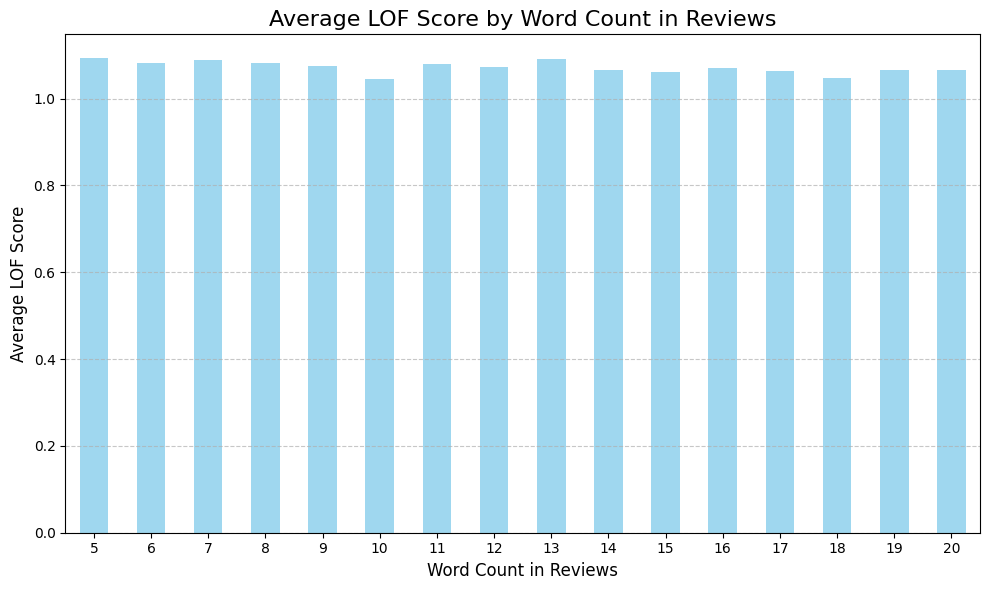

Visualization saved to average_lof_by_word_count.png


In [ ]:
# 리뷰 개수별 평균 LOF 점수 계산
average_lof_by_review_count = filtered_df.groupby('Review_Count')['LOF_Score'].mean()

# 시각화
plt.figure(figsize=(10, 6))
average_lof_by_review_count.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title("Average LOF Score by Word Count in Reviews", fontsize=16)
plt.xlabel("Word Count in Reviews", fontsize=12)
plt.ylabel("Average LOF Score", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 그래프 저장
output_path = "average_lof_by_word_count.png"
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Visualization saved to {output_path}")

## 빈도 수 기반 LOF 시도 코드

### Determine Minpts

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from tqdm import tqdm

train_df = preprocessed_df.copy()

# Step 1: Description 데이터 벡터화
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(train_df['description'])

print(X_counts.shape)

(414, 4718)


In [ ]:
# Filtering Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Step 1: TF-IDF 계산
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['description'])

# TF-IDF 단어 목록 추출
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Step 2: TF-IDF 상위 5개 단어 추출
def extract_top_keywords(tfidf_row, feature_names, top_n=5):
    # TF-IDF 값과 인덱스 추출
    sorted_indices = np.argsort(tfidf_row)[::-1]  # 내림차순 정렬
    top_indices = sorted_indices[:top_n]         # 상위 N개 선택
    top_words = feature_names[top_indices]       # 상위 단어 선택
    top_tfidf = tfidf_row[top_indices]           # 상위 TF-IDF 값 선택
    return list(zip(top_words, top_tfidf))

# 모든 문서에 대해 키워드 추출
keywords = []
for row in tfidf_matrix.toarray():
    # 각 문서에 대해 키워드 추출
    if np.sum(row) == 0:  # 문서가 비어 있을 경우 빈 리스트 추가
        keywords.append([])
    else:
        keywords.append(extract_top_keywords(row, feature_names))

# Step 3: 새로운 키워드 행렬 생성
filtered_keywords = [' '.join([word for word, _ in kw]) for kw in keywords]

# Step 4: 새로운 벡터화 수행
filtered_vectorizer = CountVectorizer(stop_words='english')
filtered_matrix = filtered_vectorizer.fit_transform(filtered_keywords)

# 결과 출력
print("Filtered Matrix Shape:", filtered_matrix.shape)

Filtered Matrix Shape: (414, 1560)


In [ ]:
filtered_keywords = [text.split() for text in filtered_keywords]

100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


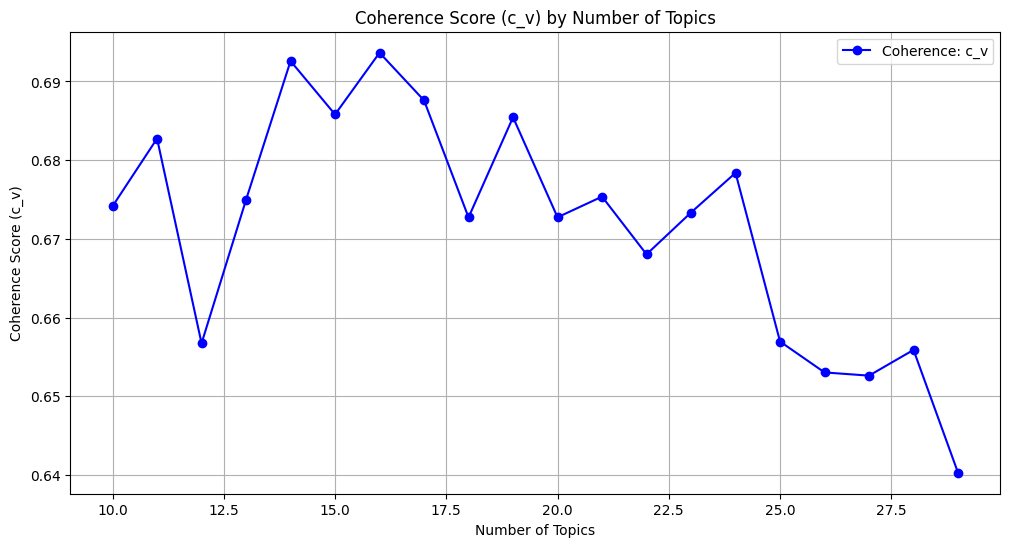

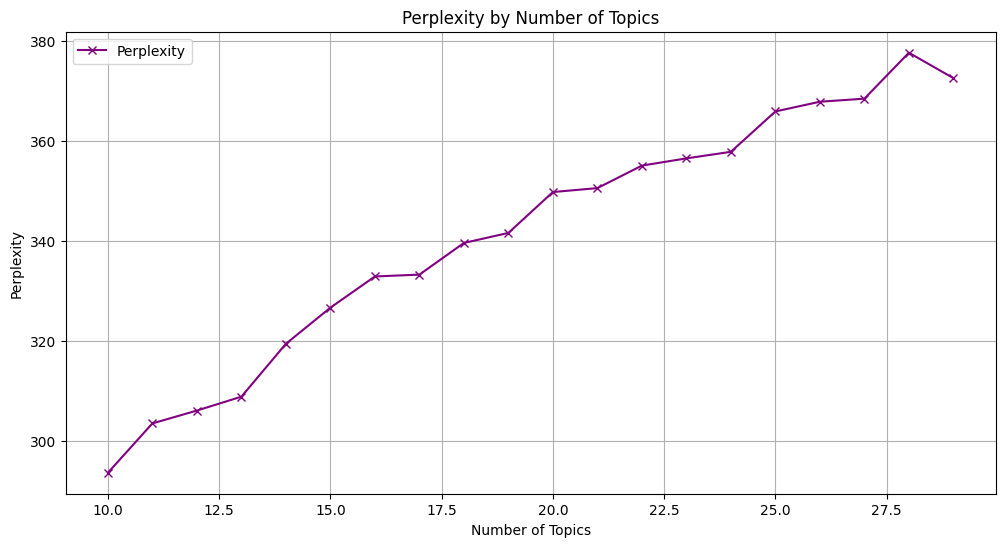

Optimal Number of Topics (c_v): 16
Optimal Number of Topics (Perplexity): 10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm

# filtered_keywords가 문자열 리스트라면, 토큰화 수행
if isinstance(filtered_keywords[0], str):
    filtered_keywords = [text.split() for text in filtered_keywords]

# 토픽 수 범위
topic_range = range(10, 30)

# c_v Coherence Score 결과 저장
c_v_scores = []
perplexities = []  # Perplexity 저장

# Gensim Dictionary와 Corpus 생성
dictionary = Dictionary(filtered_keywords)
corpus = [dictionary.doc2bow(text) for text in filtered_keywords]

# LDA 모델 학습 및 평가
for num_topics in tqdm(topic_range):
    # LDA 모델 학습
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,         # 학습 반복
        alpha='auto',      # 디리클레 분포 자동 조정
        eta='auto',        # 디리클레 분포 자동 조정
        random_state=42    # 재현성 확보
    )

    # Perplexity 계산 및 변환
    log_perplexity = lda.log_perplexity(corpus)
    perplexity = np.exp2(-log_perplexity)  # 로그-스케일에서 Perplexity로 변환
    perplexities.append(perplexity)

    # c_v Coherence Score 계산
    coherence_model = CoherenceModel(
        model=lda,
        texts=filtered_keywords,
        dictionary=dictionary,
        coherence='c_v'
    )
    c_v_scores.append(coherence_model.get_coherence())

# c_v Coherence Score 그래프
plt.figure(figsize=(12, 6))
plt.plot(topic_range, c_v_scores, color='blue', marker='o', label='Coherence: c_v')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score (c_v) by Number of Topics')
plt.legend()
plt.grid(True)
plt.show()

# Perplexity 그래프
plt.figure(figsize=(12, 6))
plt.plot(topic_range, perplexities, color='purple', marker='x', label='Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity by Number of Topics')
plt.legend()
plt.grid(True)
plt.show()

# c_v Coherence Score 기준 최적 토픽 수 선택
optimal_topics_coherence = topic_range[np.argmax(c_v_scores)]
print(f"Optimal Number of Topics (c_v): {optimal_topics_coherence}")

# Perplexity 기준 최적 토픽 수 선택
optimal_topics_perplexity = topic_range[np.argmin(perplexities)]
print(f"Optimal Number of Topics (Perplexity): {optimal_topics_perplexity}")

### Local Outlier Factor: Input

#### MinPts = 문서 수/ 토픽 수

In [ ]:
k = len(train_df) / optimal_topics_coherence
print(k)

25.875


In [ ]:
# filtered_keywords가 리스트 형태인지 확인하고 변환
if isinstance(filtered_keywords[0], str):
    filtered_keywords = [text.split() for text in filtered_keywords]

# 리스트를 공백으로 결합하여 벡터화 준비
texts = [' '.join(keywords) for keywords in filtered_keywords]

# 문서-단어 행렬 생성 (CountVectorizer 사용)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(texts)  # DTM 생성

# DTM을 데이터프레임으로 변환
feature_names = vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=feature_names)

# 결과 출력
print(f"Document-Term Matrix Shape: {dtm_df.shape}")

Document-Term Matrix Shape: (414, 1560)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: `filtered_keywords`를 텍스트 형식으로 변환
# 리스트의 리스트 형태에서 각 문서를 공백으로 결합
texts = [' '.join(keywords) for keywords in filtered_keywords]

# Step 2: TF-IDF Vectorizer 초기화 및 적합
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # 최대 단어 수 설정
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)  # TF-IDF 행렬 생성

# Step 3: TF-IDF 행렬을 데이터프레임으로 변환
feature_names = tfidf_vectorizer.get_feature_names_out()  # TF-IDF 단어(열 이름) 추출
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 결과 출력
print(f"TF-IDF Matrix Shape: {tfidf_df.shape}")  # 행렬 크기 확인

TF-IDF Matrix Shape: (414, 1560)


### Local Outlier Factor: Output

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Step 2: LOF 모델 초기화
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', novelty=False)

train_df['LOF_Score'] = -lof.fit_predict(tfidf_df)
lof_scores = -lof.negative_outlier_factor_  # LOF 점수

# 점수를 데이터프레임에 추가
train_df['LOF_Score'] = lof_scores
train_df['Novelty'] = train_df['LOF_Score'] > 1  # Novelty 기준 (1 초과)

print(f"novelty로 관광지 수: {train_df[train_df['Novelty'] == 0].shape[0]}")
print(f"일반 관광지 수: {train_df[train_df['Novelty'] == 1].shape[0]}")

# 결과 확인
train_df.head()

novelty로 관광지 수: 93
일반 관광지 수: 321


,name,description,corpus,LOF_Score,Novelty
0,Myeongdong Shopping Street,This busy shopping district is famous for its ...,busy shopping district famous beauty skincare ...,1.005517,True
1,The War Memorial of Korea,"Poignant exhibits, war memorabilia, art works,...",poignant exhibit war memorabilia art work mili...,1.044304,True
2,N Seoul Tower,"Built on a 262 meter peak in Namsan Park, the ...",build meter peak tower reach meter sea level w...,1.041185,True
3,Insadong,"Though touristy, this vibrant neighborhood is ...",touristy vibrant neighborhood cultural artisti...,1.049758,True
4,National Museum of Korea,This is the largest and most popular museum in...,large popular museum object collection permane...,0.983579,False


In [ ]:
# LOF 점수를 기준으로 상위 10개와 하위 10개 선택
top_10_lof = train_df.nlargest(10, 'LOF_Score')  # 상위 10개
bottom_10_lof = train_df.nsmallest(10, 'LOF_Score')  # 하위 10개

# 상위 10개 및 하위 10개에서 name과 description 열 출력
print("Top 10 LOF Scores:")
print(top_10_lof[['name', 'description', 'LOF_Score']])

print("\nBottom 10 LOF Scores:")
print(bottom_10_lof[['name', 'description', 'LOF_Score']])

Top 10 LOF Scores:
                                                  name  \
240                                       Paint'n Clay   
212                                   Jankura Artspace   
298                               Gyobokmall - Hongdae   
29                                         Boksoondoga   
356                                     Han Collection   
360                                    Arirang Brewery   
269  oneworld Lounge (ICN) Incheon International Ai...   
28                                             Itaewon   
272                                      Teterot Salon   
248                                       Mediheal spa   

                                           description  LOF_Score  
240  Paint'n Clay is a walk in paint your own potte...   1.041317  
212  Jankura Artspace is Seoul's first foreign owne...   1.039679  
298  School uniform is always fun and flutter! If y...   1.038466  
29   Boksoondoga, a Premium, Home-brewed Makgeolli ...   1.037985  
35

In [ ]:
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/inbound_service/dataset/output.csv')
df.head()